# Bigram

## Hazırlık

In [1]:
# gerekli kütüphaneler
import torch
import matplotlib.pyplot as plt

# alfabeye ihityacımız var
alfabe = ['.', 'a','b','c','ç','d','e','f','g','ğ','h','ı','i','j','k','l','m','n','o','ö','p','r','s','ş','t','u','ü','v','y','z']
# harfin alfabedeki sırasına da ihtiyacımız var
harf2idx = { harf:idx for idx, harf in enumerate(alfabe) }
# bunun tersine de ihtiyacımız olacak
idx2harf = { idx:harf for harf, idx in harf2idx.items() }
# başlamadan önce isimleri de okuyalım
isimler = open("../isimler.txt", "r").read().splitlines()

## Ne yapmak istemiyoruz?

Rastgele harfleri arka arkaya getirdiğimizde elimizdeki yer isimlerini geçelim anlamlı bir kelime üretmemiz bile çok zor:

In [2]:
# detayı önemli değil
g = torch.Generator().manual_seed(234327037)
for i in range(10):
    ornek = []
    idx = 0
    while True:
        p = torch.ones(30) / 30.0
        idx = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        if idx == 0:
            break
        ornek.append(idx2harf[idx])
    print(''.join(ornek))

gjbişrmyyçp
eığiacıkj
ıvdunuavmikahşagahizcgloğmhşl
iljceydhrdtü
küğğmyzsdfyörçtptfiğjgzskohoms
aylerpaiühoebşhbipmogrmvrğpygyhötsıhtefehkı
fğöpirçbbsvfçnpgvdçlbrjr
öğskggğbltcmıalyhtlhzykuçifmojpüagctıhvşuuiyınöcşlgpkjazhmbglopb
pomhlchhguipiakhjüh
ıapcrraövdcblcipzupbbölsrzabjtboucşhgsşleüöçdeelöeikhujeugüşkosjshg


## Ne yapabiliriz?

Rastgele harfleri arka arkaya dizerek bir sonuç elde edemeyeceğimizi gördük.

_Bigram_ (aslında herhangi) bir modelden önce ne beklediğimize karar verelim; sonra oraya nasıl gideceğimize bakarız:

* eldeki verinin istatistiksel özelliklerine dikkat ederek rastgele bir harf seçmeli
* bu harfe yine verinin özelliklerine bakarak (yine rastgele) bir harf daha eklemeli veya durmaya karar vermeli.

> Yani modelin budur deyip bize verdiği isim yeni olmakla birlikte eldekileri andırabilecek kadar benzer olmalı.

İşte burada _bigram_ deyip durduğumuz şey devreye giriyor: harflerin rastgele arka arkaya gelerek isimler oluşturmadığını anladığımıza göre yapabileceğimiz ilk ve en basit şey harflerin birbirini hangi sıklıkta takip ettiğini incelemek.

## Bir isim üzerinde çalışalım

Bir isim içinde bir harfin diğerini takip etme sıklığını hesaplamak istiyorsak, öncelikle harfleri bu şekilde görebilmemiz gerekiyor. Bunu yapmak için ismin kendisini ve 2. harfi ile başlayan _oynanmış_ halini birbirine `zip` ile bağlayalım ve harfleri çiftler halinde görelim:

In [3]:
isim = isimler[3] 
print(f'{isim}:')
for h1, h2 in zip(isim, isim[1:]):
    print(h1, h2)

abacılar:
a b
b a
a c
c ı
ı l
l a
a r


Burada aslında görmediğimiz bir bilgi daha var: her isim başlıyor ve bitiyor. Örnek olarak seçtiğimiz isim _a_ harfi ile başlayıp _r_ harfi ile bitiyor. Bu bilgiyi de görebileceğimiz şekilde bir daha deneyelim:

In [4]:
isim = ['.'] + list(isim) + ['.']
for h1, h2 in zip(isim, isim[1:]):
    print(h1, h2)

. a
a b
b a
a c
c ı
ı l
l a
a r
r .


## Frekansları hesaplayalım

In [5]:
bigramlar = {}
for x in isimler:
    isim = ['.'] + list(x) + ['.']
    for k1, k2 in zip(isim, isim[1:]):
        b = (k1, k2)
        bigramlar[b] = bigramlar.get(b, 0) + 1

In [6]:
sorted(bigramlar.items(), key = lambda x: -x[1])

[(('a', 'r'), 6478),
 (('.', 'k'), 5080),
 (('k', 'a'), 4350),
 (('r', '.'), 4200),
 (('ı', '.'), 3999),
 (('a', 'n'), 3926),
 (('l', 'a'), 3821),
 (('e', 'r'), 3643),
 (('a', 'l'), 3584),
 (('.', 'a'), 3140),
 (('a', 'k'), 3130),
 (('k', '.'), 2896),
 (('l', 'ı'), 2774),
 (('l', 'i'), 2653),
 (('n', '.'), 2641),
 (('i', '.'), 2623),
 (('b', 'a'), 2513),
 (('r', 'a'), 2433),
 (('a', '.'), 2432),
 (('u', '.'), 2429),
 (('e', 'n'), 2401),
 (('a', 'ğ'), 2370),
 (('.', 'y'), 2354),
 (('l', 'u'), 2352),
 (('y', 'a'), 2336),
 (('.', 'b'), 2331),
 (('a', 'y'), 2310),
 (('e', '.'), 2213),
 (('l', 'e'), 2173),
 (('a', 'ş'), 2151),
 (('.', 's'), 2079),
 (('r', 'e'), 1886),
 (('h', 'a'), 1860),
 (('d', 'e'), 1856),
 (('m', 'a'), 1850),
 (('t', 'a'), 1821),
 (('.', 'd'), 1785),
 (('o', 'ğ'), 1773),
 (('e', 'l'), 1770),
 (('s', 'a'), 1746),
 (('m', 'e'), 1706),
 (('.', 'ç'), 1699),
 (('ç', 'a'), 1698),
 (('r', 'ı'), 1619),
 (('.', 'g'), 1618),
 (('ı', 'k'), 1605),
 (('ş', 'a'), 1530),
 (('e', 'k'),

### Hızlıca sonuçlara göz atalım

- _r_ harfi 6478 kez _a_ harfini takip ediyor.
- elimizdeki veri setinde _k_ harfiyle başlayan 5080 isim var; bunu 3140 ile _a_ harfi takip ediyor. Dolayısıyla şunu bekleyebiliriz: modelimizin yeni bir isim üretirken _k_, _a_ gibi harflerle başlama olasılığı daha yüksek olmalı.
- benzer şekilde _r_ ve _ı_ harfleri 4 bin civarı ismin bitişinde bulunuyor. Benzer şekilde modelin ürettiği isimleri bitirirken bu harfleri daha sık kullanmasını bekleyebiliriz.

Hem görselleştirmek hem de amacımıza uygun kullanmak adına `dictionary` yerine bu veriyi 2 boyutlu bir matris ile temsil edelim. Matrisin:

- satırlar çiftin ilk harfini
- sütunlar çiftin ikinci harfini
- hücreler ise bu çiftin frekansını 

göstersin. Bunu yapmak için _pytorch_ kütüphanesindeki `tensor` yapısından istifade edeceğiz.

## 2d Matris

### Matrisi oluşturalım

In [7]:
M = torch.zeros((30, 30), dtype = torch.int32)
for isim in isimler:
    isim = ['.'] + list(isim) + ['.']
    for h1, h2 in zip(isim, isim[1:]):
        i1 = harf2idx[h1]
        i2 = harf2idx[h2]
        M[i1, i2] += 1

### Görselleştirelim

(-0.5, 29.5, 29.5, -0.5)

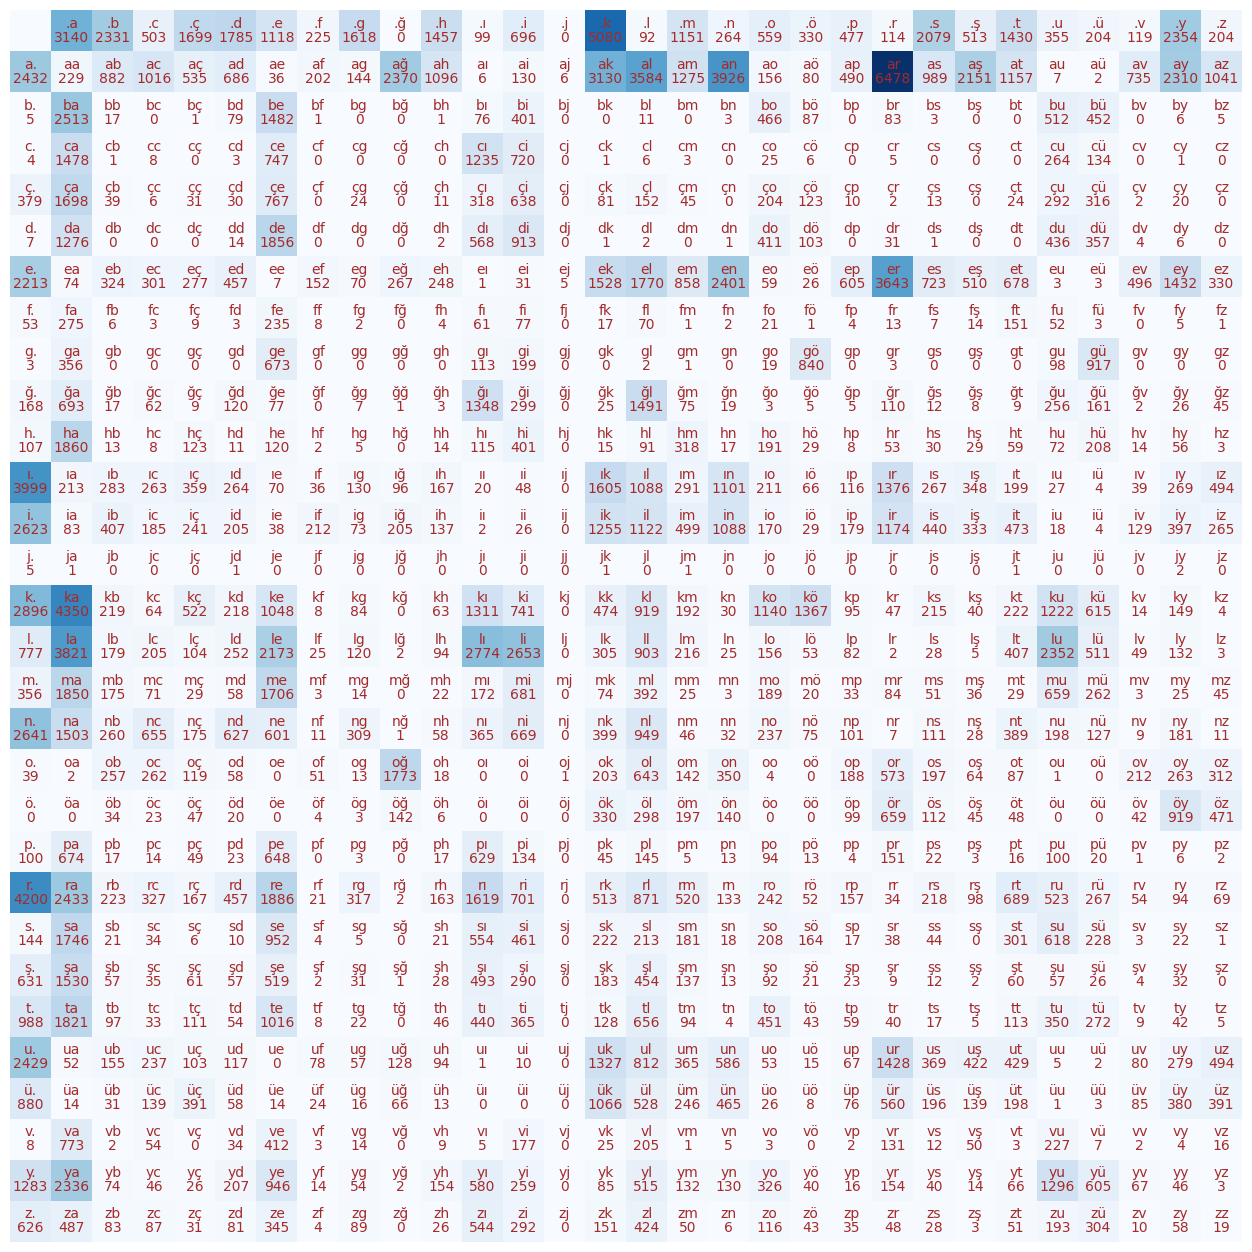

In [8]:
plt.figure(figsize = (16, 16))
plt.imshow(M, cmap = 'Blues')
for i in range(30):
    for j in range(30):
        if i == 0 and j == 0: continue
        plt.text(j, i, idx2harf[i] + idx2harf[j], ha = 'center', va = 'bottom', color = 'brown')
        plt.text(j, i, M[i, j].item(), ha = 'center', va = 'top', color = 'brown')
plt.axis('off')

### 📢

`j` harfinin `j` harfini takip etme frekansı 0, bu aşamada önemli olmasa da bununla (_jj_ ile ilgili değil, matriste 0 hücrelerin olması ile) ilgili ileride bir sorun yaşayacağız. Bir ipucu vereyim: `smoothing`.

## Frekanstan Olasılığa

Elimizdeki matris her harfin kaç kez isim başlattığını/bitirdiğini ve başka bir harfi takip ettiğini gösteriyor. Bu bilgi kıymetli olsa da yapmak istediğimiz şey için pek uygun sayılmaz. Her bir satır içindeki olasılığı hesaplamak bizi amacımıza bir adım daha yaklaştıracak.

İlk satır, yani bir harfin isim başlatma durumu için olasılık hesaplayalım:

In [9]:
p = M[0].float() / M[0].sum()
for i, x in sorted(enumerate(p), key=lambda t: -t[1].item())[:5]:
    print(f"{idx2harf[i]} : {x:.2f}")

print(f'bir ismin başlama olasılığı: {p.sum()} yani eldeki veriye göre {M[0].sum()} kez başlamış')

#len(isimler)

k : 0.17
a : 0.10
y : 0.08
b : 0.08
s : 0.07
bir ismin başlama olasılığı: 1.0 yani eldeki veriye göre 29996 kez başlamış


Olasılığa dönerek şunu bulduk:

* bir isim mutlaka başlar :)
* %17 olasılıkla _k_ ile başlar
* %10 olasılıkla _a_ ile başlar
* ...

Aynı işlemi `M`deki tüm satırlar için yaptığımızda harflerin birbirini takip etme olasılıklarıyla birlikte isim başlatma/bitirme olasılıklarını da bulmuş olacağız.

In [10]:
P = M.float()
P = P / P.sum(dim = 1, keepdim = True)

### ⚠️
Her satırı kendi toplamına bölüyoruz; bu işlemi bir _çırpıda_ yapmamıza yardımcı olan `tensor` yapısını toplama ve bu yeni tensörü diğerini bölmede kullanış şeklimize dikkat edin! Bunu mümkün kılan `broadcasting` [kurallarına](https://pytorch.org/docs/stable/notes/broadcasting.html) dikkat etmezseniz çok üzebilir.


## Sonuç

Bu olasılıkları dikkate alarak rastgele harflerden isim oluşturmayı deneyelim:

In [41]:
g = torch.Generator().manual_seed(5)
for i in range(25):
    ornek = ['.']
    idx = 0
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        ornek.append(idx2harf[idx])
        if idx == 0:
            break
    print(''.join(ornek))
    idx = 0

.kadur.
.ç.
.mavardu.
.ü.
.tentli.
.megükeritenaem.
.güksıkılı.
.klar.
.derı.
.gücıkçazukçdinı.
.ç.
.cınakü.
.dekla.
.ıcıçıcateyı.
.atucık.
.ti.
.koy.
.pene.
.yullefı.
.maleğındirgöyu.
.kopradot.
.hat.
.k.
.kasin.
.bukçedoğun.
